In [251]:
"""Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)"""

'Columns\nid - a unique identifier for each tweet\ntext - the text of the tweet\nlocation - the location the tweet was sent from (may be blank)\nkeyword - a particular keyword from the tweet (may be blank)\ntarget - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)'

In [252]:
#Importing all libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from wordcloud import WordCloud
import missingno


%matplotlib inline
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer


from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import svm


import xgboost as xgb
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [253]:
train = pd.read_csv("train.csv")
test= pd.read_csv("test.csv")

In [254]:
#No of rows and columns
train.shape

(7613, 5)

In [255]:
#Prints first 5 rows
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [256]:
train["location"].value_counts()

USA                             104
New York                         71
United States                    50
London                           45
Canada                           29
                               ... 
??? ???? ?f glory. ?              1
Newton Centre, Massachusetts      1
Bracknell                         1
Lancashire, United Kingdom        1
Fredonia,NY                       1
Name: location, Length: 3341, dtype: int64

In [257]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [258]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [259]:
#checking for null values
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [260]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [261]:
#Remove redundant samples
train=train.drop_duplicates(subset=['text', 'target'], keep='first')
train.shape

(7521, 5)

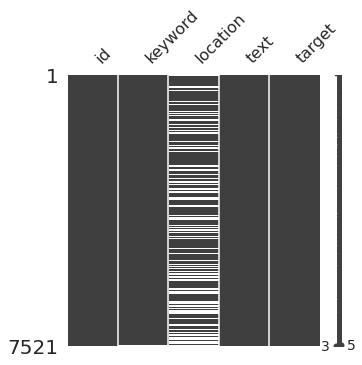

In [262]:
#plot graph for missing values

missingno.matrix(train, figsize = (5,5))

In [263]:
#location is having most number of null values

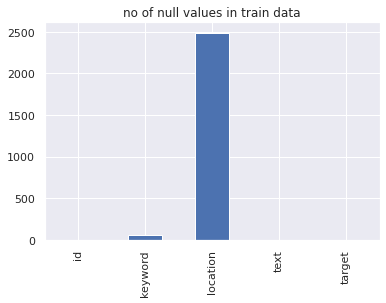

In [264]:
train.isna().sum().plot(kind="bar")
plt.title("no of null values in train data")
plt.show()

In [265]:
#Location with maximum null values
#Keyword follows Location with null values

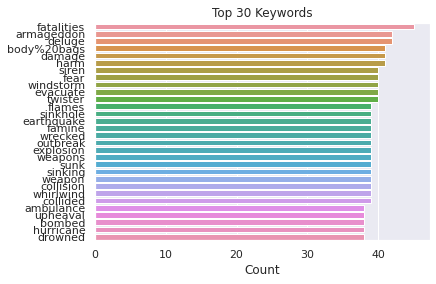

In [266]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')
plt.title("Top 30 Keywords")
plt.show()

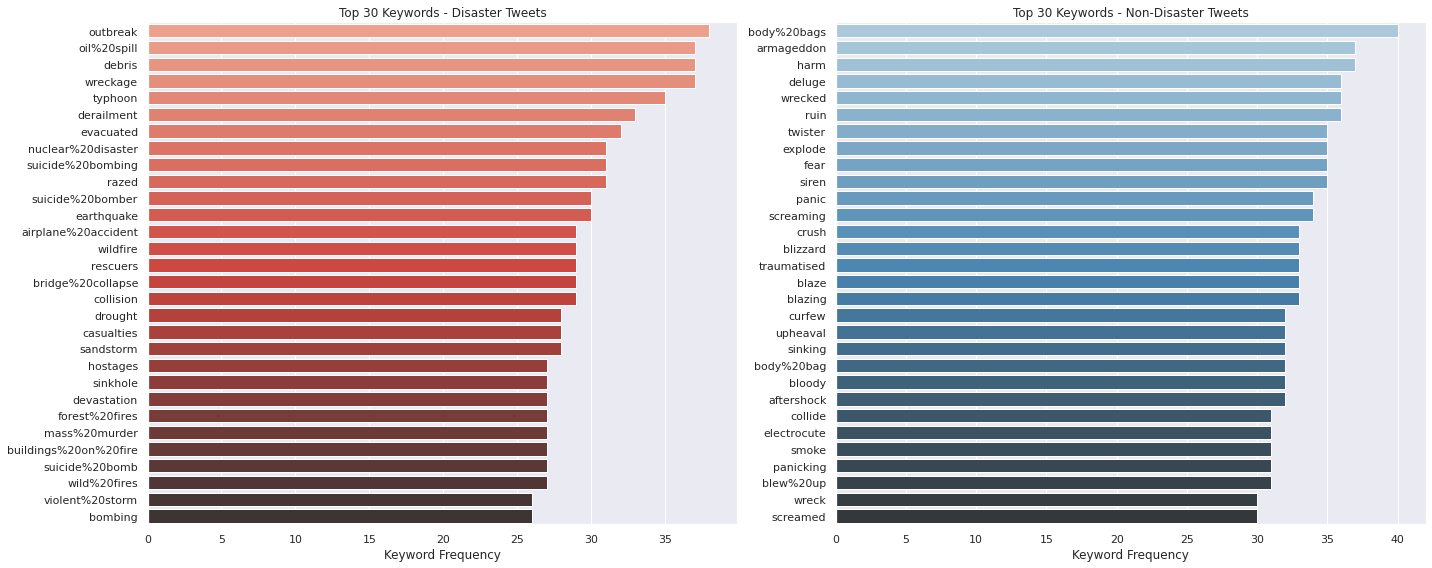

In [267]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

In [268]:
# drop location and keyword column
train = train.drop(['location','keyword'],axis=1)
test = test.drop(['location','keyword'],axis=1)

In [269]:
train.head(5)

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [270]:
#Let check how many real tweets and fake tweets

tweetreal = len(train[train["target"]==1])

In [271]:
#percentage of real tweets
RealTweetPercentage = tweetreal/train.shape[0]*100
RealTweetPercentage

42.62731019811195

In [272]:
#Percentage of fake tweet
FakeTweetPercentage = 100-RealTweetPercentage
FakeTweetPercentage

57.37268980188805

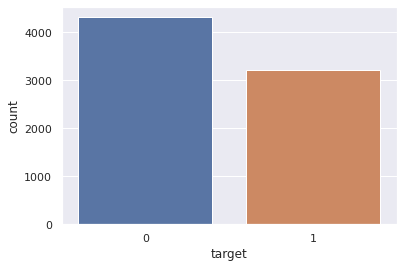

In [273]:
#plot target variables
sns.countplot(x ='target', data= train)

(array([ 35., 111., 153., 218., 272., 408., 388., 386., 755., 537.]),
 array([  5. ,  19.6,  34.2,  48.8,  63.4,  78. ,  92.6, 107.2, 121.8,
        136.4, 151. ]),
 <a list of 10 Patch objects>)

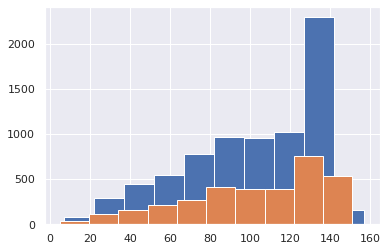

In [274]:
#Now lets understand the density of tweets in both test and train dataset.

den_train = train['text'].str.len()
den_test = test['text'].str.len()

plt.hist(den_train, label = "train_tweets")
plt.hist(den_test, label= "text_tweets")

In [275]:
#So here train data is having more tweets compared to the test data.

In [276]:
#Fetch wordcount for each abstract
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
train[['text','word_count']].head(10)

,text,word_count
0,Our Deeds are the Reason of this #earthquake M...,13
1,Forest fire near La Ronge Sask. Canada,7
2,All residents asked to 'shelter in place' are ...,22
3,"13,000 people receive #wildfires evacuation or...",9
4,Just got sent this photo from Ruby #Alaska as ...,17
5,#RockyFire Update => California Hwy. 20 closed...,18
6,#flood #disaster Heavy rain causes flash flood...,14
7,I'm on top of the hill and I can see a fire in...,15
8,There's an emergency evacuation happening now ...,12
9,I'm afraid that the tornado is coming to our a...,10


In [277]:
##Descriptive statistics of word counts
train.word_count.describe()

#The average word count is about 15 words per abstract. The word count ranges from a minimum of 1 to a maximum of 54.

count    7521.000000
mean       14.905731
std         5.787714
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        54.000000
Name: word_count, dtype: float64

In [278]:
#Identify common words: Its the frequently used words as well as it could be potential data specific stop words.
import pandas as pd

freq = pd.Series(' '.join(train['text']).split()).value_counts()[:20]
freq

the     2542
a       1816
to      1788
in      1728
of      1685
and     1285
I       1192
for      804
is       801
on       760
-        757
you      618
The      546
my       545
with     488
that     486
at       476
by       462
it       421
be       364
dtype: int64

In [279]:
#Identify uncommon words: Uncommon words in the train dataset
freq1 =  pd.Series(' '.join(train ['text']).split()).value_counts()[-20:]
freq1

#Zimmerman                1
petition!                 1
strives                   1
Libya;                    1
Trailer                   1
offsite                   1
Buscemi                   1
them'@Ayhoka_:            1
#brixton                  1
http://t.co/QVlxpyyyCd    1
Deco                      1
@stupid_niggr             1
Romford                   1
#SouthKorea               1
monarchy                  1
#pussy                    1
REGISTER]                 1
HERE:'                    1
@Tunes_WGG                1
Derivatives:              1
dtype: int64

In [280]:
#Disaster tweet

disaster_tweets = train[train['target'] ==1 ]['text']
for i in range(1,10):
    print(disaster_tweets[i])

Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...


In [281]:
# non-disaster tweets
non_disaster_tweets = train[train['target'] !=1 ]['text']
non_disaster_tweets

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4315, dtype: object

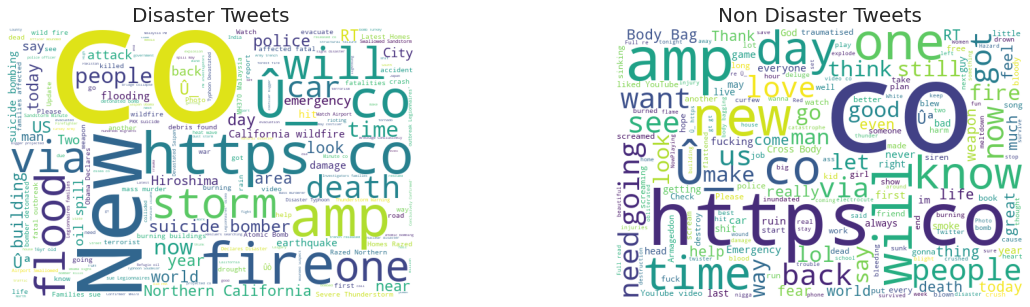

In [282]:
#wordcloud

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=20);


wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=20);


In [283]:
train.head(5)

,id,text,target,word_count
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


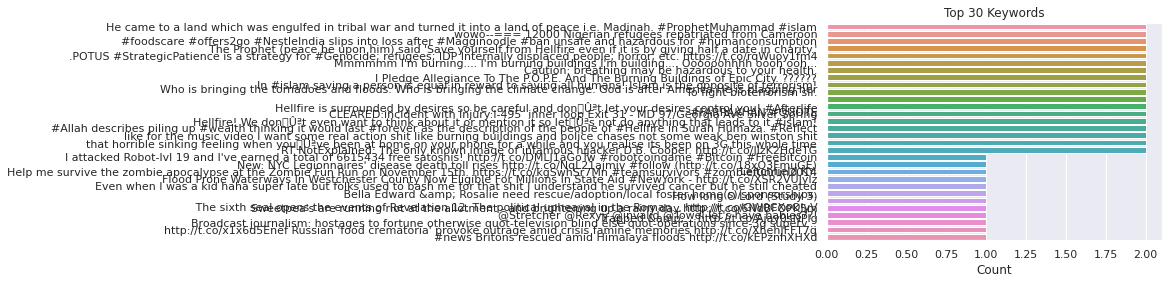

In [284]:
#Commonly used keywords

keywords_vc = pd.DataFrame({"Count": train["text"].value_counts()})
sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')
plt.title("Top 30 Keywords")
plt.show()

In [285]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Cleaning

Now lets do **Text-preprocessing**:
1. Reduce sparsity
2. Text clean-up
3. Shrinkage the vocabulary to retain only the relevant words

Text preprocessing
1: Noise Removal

      a: Removing redundant text components

      b: Punctuations, Tags, URL, stopwords

2: Normalization

      a: Stemming - Remove suffixes
      b: Lemmatization- Works based on the roots of the word 






In [286]:
#Normalization is the method of handling multiple occurances of the same word
#Stemming normalizes text by removing suffixes.
#Lemmatisation is a more advanced technique which works based on the root of the word.


We have 92 redundants sapmles in our dataset (7613-7521)=92

---



In [287]:
#After removing all the redundant values lets check te counts
train.target.value_counts()

0    4315
1    3206
Name: target, dtype: int64

In [288]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [289]:
#List of punctuations and we will remove them from our corpus
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [290]:
#Cleaning data

In [291]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [292]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [293]:
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [294]:
tweets = train["text"]

In [295]:
#Tokenize


tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x:tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x:tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [296]:
#Removing stopwords


def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words 
train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
test.head()

,id,text
0,0,"[happened, terrible, car, crash]"
1,2,"[heard, earthquake, different, cities, stay, s..."
2,3,"[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,"[apocalypse, lighting, spokane, wildfires]"
4,11,"[typhoon, soudelor, kills, china, taiwan]"


In [297]:
disaster_tweets = train[train['target'] ==1 ]['text']
for i in range(1,10):
    print(disaster_tweets[i])

['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']
['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california']
['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pours', 'school']
['rockyfire', 'update', 'california', 'hwy', 'closed', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfires']
['flood', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'streets', 'manitou', 'colorado', 'springs', 'areas']
['im', 'top', 'hill', 'see', 'fire', 'woods']
['theres', 'emergency', 'evacuation', 'happening', 'building', 'across', 'street']
['im', 'afraid', 'tornado', 'coming', 'area']


In [298]:
# non-disaster tweets
non_disaster_tweets = train[train['target'] !=1 ]['text']
non_disaster_tweets.head()

15         [whats, man]
16       [love, fruits]
17     [summer, lovely]
18          [car, fast]
19    [goooooooaaaaaal]
Name: text, dtype: object

In [299]:
#Lemmatization

nltk.download()
import nltk
nltk.download('averaged_perceptron_tagger')

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [300]:
import nltk
nltk.download('wordnet')







nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [301]:
# lemmatization
lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]

    

In [302]:
train['text'] = train['text'].apply(lem_word)
test['text'] = test['text'].apply(lem_word)

In [303]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,text,target,word_count
0,1,deed reason earthquake may allah forgive u,1,13
1,4,forest fire near la ronge sask canada,1,7
2,5,resident asked shelter place notified officer ...,1,22
3,6,people receive wildfire evacuation order calif...,1,9
4,7,got sent photo ruby alaska smoke wildfire pour...,1,17


In [304]:
import nltk; 
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [305]:
#Import all libraries for preprocessing

import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from nltk.stem.wordnet import WordNetLemmatizer


In [306]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stem = PorterStemmer()

nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [307]:
#CountVectorizer

In [308]:
count_vectorizer = CountVectorizer()
train_vector = count_vectorizer.fit_transform(train['text'])
test_vector = count_vectorizer.transform(test['text'])
print(train_vector[0].todense())

[[0 0 0 ... 0 0 0]]


In [309]:
#TF IDF

tfidf = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])



In [310]:
test_tfidf

<3263x10417 sparse matrix of type '<class 'numpy.float64'>'
	with 28493 stored elements in Compressed Sparse Row format>

In [311]:
mnb = MultinomialNB(alpha = 2.0)
scores_vector = model_selection.cross_val_score(mnb,train_vector,train['target'],cv = 10,scoring = 'f1')
print("score:",scores_vector)
scores_tfidf = model_selection.cross_val_score(mnb,train_tfidf,train['target'],cv = 10,scoring = 'f1')
print("score of tfidf:",scores_tfidf)

score: [0.68118196 0.56110155 0.57738095 0.53608247 0.66081871 0.63065693
 0.66969697 0.59495798 0.7140825  0.74105866]
score of tfidf: [0.61448141 0.48172043 0.57407407 0.44921875 0.57454545 0.51879699
 0.57965451 0.525      0.71304348 0.75250836]


In [312]:
mnb.get_params()

{'alpha': 2.0, 'class_prior': None, 'fit_prior': True}

In [313]:
#Logistic Regression

In [314]:
lg = LogisticRegression(C = 1.0)
scores_vector = model_selection.cross_val_score(lg, train_vector, train["target"], cv = 5, scoring = "f1")
print("score:",scores_vector)
scores_tfidf = model_selection.cross_val_score(lg, train_tfidf, train["target"], cv = 5, scoring = "f1")
print("score of tfidf:",scores_tfidf)

score: [0.62620424 0.52493438 0.57263514 0.53410183 0.696     ]
score of tfidf: [0.59137577 0.49099526 0.5498155  0.44685466 0.66547085]


In [315]:
lg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [316]:
mnb.fit(train_tfidf, train["target"])
y_pred = mnb.predict(test_tfidf)

In [317]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

Submission

In [325]:
submission_file = pd.DataFrame({'Id':test['id'],'target':y_pred})

In [326]:
submission_file.to_csv('submission_file.csv',index=False)

In [327]:
submission_file = pd.read_csv('submission_file.csv')

In [328]:
submission_file.head(10)

,Id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


Text preparation

In [320]:
"""Text in the corpus needs to be converted to a format that can be interpreted by the machine learning algorithms. There are 2 parts of this conversion — Tokenisation and Vectorisation."""

'Text in the corpus needs to be converted to a format that can be interpreted by the machine learning algorithms. There are 2 parts of this conversion — Tokenisation and Vectorisation.'

In [321]:
"""Tokenisation is the process of converting the continuous text into a list of words. The list of words is then converted to a matrix of integers by the process of vectorisation. Vectorisation is also called feature extraction."""

'Tokenisation is the process of converting the continuous text into a list of words. The list of words is then converted to a matrix of integers by the process of vectorisation. Vectorisation is also called feature extraction.'

In [322]:
"""For text preparation we use the bag of words model which ignores the sequence of the words and only considers word frequencies."""

'For text preparation we use the bag of words model which ignores the sequence of the words and only considers word frequencies.'